In [ ]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import random
from copy import deepcopy
import pandas as pd
from scipy.stats import spearmanr, norm
import argparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

%pip install torch fair-esm transformers
import esm
import sklearn
#from Bio import PDB
#from Bio.PDB.DSSP import DSSP
#from Bio.SubsMat import MatrixInfo as mat

from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from scipy.stats import spearmanr
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

## 1. Retrieve and Preprocess Data

In [ ]:
with open('data/sequence.fasta', 'r') as f:
  data = f.readlines()

sequence_wt = data[1].strip()
sequence_wt

'MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP'

In [27]:
def get_mutated_sequence(mut, sequence_wt):
  wt, pos, mt = mut[0], int(mut[1:-1]), mut[-1]

  sequence = deepcopy(sequence_wt)

  return sequence[:pos]+mt+sequence[pos+1:]

In [ ]:
df_train = pd.read_csv('data/train.csv')
df_train['sequence'] = df_train.mutant.apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_train

mutant  DMS_score                                           sequence
0       M0Y     0.2730  YVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1       M0W     0.2857  WVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
2       M0V     0.2153  VVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
3       M0T     0.3122  TVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
4       M0S     0.2180  SVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
...     ...        ...                                                ...
1135  P347D     0.3876  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1136  P347C     0.1837  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1137  P347A     0.4611  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1138  P347M     0.2412  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1139  P347H     0.1512  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...

[1140 rows x 3 columns]

In [ ]:
df_test_og = pd.read_csv('data/test.csv')
df_test_og['sequence'] = df_test_og.mutant.apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_test_og

mutant                                           sequence
0        V1D  MDNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1        V1Y  MYNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
2        V1C  MCNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
3        V1A  MANEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
4        V1E  MENEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
...      ...                                                ...
11319  P655S  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
11320  P655T  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
11321  P655V  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
11322  P655A  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
11323  P655W  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...

[11324 rows x 2 columns]

In [30]:
query1 = pd.read_csv('query1.csv')
df_train = pd.concat([df_train, query1], ignore_index=True)
df_train.tail()
print(df_train.shape)

# remove query data from df_test
df_test = df_test_og.copy()
cond = df_test['mutant'].isin(query1['mutant'])
df_test.drop(df_test[cond].index, inplace = True)

(1240, 3)


In [31]:
query2 = pd.read_csv('query2.csv')
df_train = pd.concat([df_train, query2], ignore_index=True)
df_train.tail()
print(df_train.shape)

# remove query data from df_test
cond = df_test['mutant'].isin(query2['mutant'])
df_test.drop(df_test[cond].index, inplace = True)

(1340, 3)


In [39]:
query3 = pd.read_csv('query3.csv')
df_train = pd.concat([df_train, query3], ignore_index=True)
df_train.tail()
print(df_train.shape)

(1440, 3)


## 2. ESM Model

create mutant embeddings to train the model on

### 2.1 Mutant Embeddings

use the pretrained ESM2 model to get mutant embeddings

In [40]:
# load pretrained ESM2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [41]:
# process the input sequence into the format that ESM2 model can take
def get_esm2_embedding(sequence):
    batch_labels, batch_strs, batch_tokens = batch_converter([(sequence, sequence)])
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=False)

    token_representations = results["representations"][33]
    sequence_embedding = token_representations.mean(dim=1).squeeze().numpy()
    return sequence_embedding

In [44]:
# extract embeddings for the mutant sequence
mutant_embeddings = []
for mutant in df_train['mutant']:
    mutant_embedding = get_esm2_embedding(df_train[df_train['mutant'] == mutant]['sequence'].values[0])
    mutant_embeddings.append(mutant_embedding)

mutant_embeddings = np.array(mutant_embeddings)
np.save('mutant_embeddings.npy', mutant_embeddings)

In [ ]:
mutant_embeddings = np.load('mutant_embeddings.npy')

### 2.2 One Hot Encoding

create a one hot encoding function to encode all amino acids, convert all mutants into one-hot encodings and add to training data

In [89]:
AA_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"  # standard 20 amino acids
aa_to_index = {aa: i for i, aa in enumerate(AA_ALPHABET)}  # map each AA to index


def one_hot_encode_mutant(mutant, max_pos):
    """
    Converts a mutation (e.g., 'A10V') into a one-hot encoded vector
    """
    # extract the wild type (wt), position (pos), and mutant (mut) amino acids
    wt, pos, mut = mutant[0], mutant[1:-1], mutant[-1] 
    pos = int(pos)  
    
    # one-hot encoding
    one_hot = np.zeros(len(AA_ALPHABET) * 2)  # 2 for WT and MUT
    one_hot[aa_to_index[wt]] = 1  # encode WT
    one_hot[len(AA_ALPHABET) + aa_to_index[mut]] = 1  # encode MUT

    # position encoding
    pos_norm = np.array([pos / max_pos])
    
    return np.concatenate((one_hot, pos_norm), axis=0)

# convert train mutants to one-hot encodings
max_pos = df_train['mutant'].apply(lambda x: int(x[1:-1])).max()  # find the maximum position in the dataset
mutant_one_hot_encodings = np.array([one_hot_encode_mutant(m, max_pos) for m in df_train['mutant']])
np.save('mutant_one_hot.npy', mutant_one_hot_encodings)

In [ ]:
mutant_one_hot = np.load('mutant_one_hot.npy')

In [90]:
enhanced_features = np.hstack([mutant_embeddings, mutant_one_hot])

# Save combined feature matrix
np.save("enhanced_mutant_features.npy", enhanced_features)

### 2.3 Blosum Score

calculate the Blosum Score as a feature, not used since the library does not work this way

In [49]:
def blosum_score(mutant):
    """
    Calculate the BLOSUM62 score for a given mutation.
    """
    # extract the wild type (wt), position (pos), and mutant (mut) amino acids
    wt, pos, mut = mutant[0], mutant[1:-1], mutant[-1] 
    pos = int(pos)  
    
    # calculate the BLOSUM62 score
    score = mat.blosum62[wt][mut]
    
    return score

# Calculate BLOSUM62 scores for all mutants
blosum_scores = np.array([blosum_score(m) for m in df_train['mutant']])
np.save('blosum_scores.npy', blosum_scores)
blosum_scores.shape

NameError: name 'mat' is not defined

In [ ]:
blosum_scores = np.load('blosum_scores.npy')

In [ ]:
# Load embeddings and new features
mutant_embeddings = np.load("mutant_embeddings.npy")
mutant_one_hot = np.load("mutant_one_hot.npy")
#blosum_scores = np.load("blosum_scores.npy")

# Concatenate features
enhanced_features = np.hstack([mutant_embeddings, mutant_one_hot, blosum_scores.reshape(-1, 1)])

# Save combined feature matrix
np.save("enhanced_mutant_features.npy", enhanced_features)

### 2.4 Physiochemical Properties

find the physiochemical properties associated to the mutants and add them as a feature to the training data

In [117]:
# extract charge information from: https://www.thermofisher.com/us/en/home/life-science/protein-biology/protein-biology-learning-center/protein-biology-resource-library/pierce-protein-methods/amino-acid-physical-properties.html
# extraced molecular weight information from: https://www.sigmaaldrich.com/US/en/technical-documents/technical-article/protein-biology/protein-structural-analysis/amino-acid-reference-chart
# extracted hydrophobicity information from: https://www.rbvi.ucsf.edu/chimera/docs/UsersGuide/midas/hydrophob.html
amino_acid_properties = {
    'A': {'charge': 0, 'hydrophobicity': 1.8, 'weight': 89.1},
    'C': {'charge': 0, 'hydrophobicity': 2.5, 'weight': 121.2},
    'D': {'charge': -1, 'hydrophobicity': -3.5, 'weight': 133.1},
    'E': {'charge': -1, 'hydrophobicity': -3.5, 'weight': 147.1},
    'F': {'charge': 0, 'hydrophobicity': 2.8, 'weight': 165.2},
    'G': {'charge': 0, 'hydrophobicity': -0.4, 'weight': 75.1},
    'H': {'charge': 0, 'hydrophobicity': -3.2, 'weight': 155.2},
    'I': {'charge': 0, 'hydrophobicity': 4.5, 'weight': 131.2},
    'K': {'charge': 1, 'hydrophobicity': -3.9, 'weight': 146.2},
    'L': {'charge': 0, 'hydrophobicity': 3.8, 'weight': 131.2},
    'M': {'charge': 0, 'hydrophobicity': 1.9, 'weight': 149.2},
    'N': {'charge': 0, 'hydrophobicity': -3.5, 'weight': 132.1},
    'P': {'charge': 0, 'hydrophobicity': -1.6, 'weight': 115.1},
    'Q': {'charge': 0, 'hydrophobicity': -3.5, 'weight': 146.2},
    'R': {'charge': 1, 'hydrophobicity': -4.5, 'weight': 174.2},
    'S': {'charge': 0, 'hydrophobicity': -0.8, 'weight': 105.1},
    'T': {'charge': 0, 'hydrophobicity': -0.7, 'weight': 119.2},
    'V': {'charge': 0, 'hydrophobicity': 4.2, 'weight': 117.1},
    'W': {'charge': 0, 'hydrophobicity': -0.9, 'weight': 204.2},
    'Y': {'charge': 0, 'hydrophobicity': -1.3, 'weight': 181.2}
}

In [118]:
def get_amino_acid_features(mutant):
    """
    Get the features (charge, hydrophobicity, molecular weight) for a given amino acid.
    """
    # extract the wild type (wt), position (pos), and mutant (mut) amino acids
    wt, pos, mut = mutant[0], mutant[1:-1], mutant[-1] 
    pos = int(pos)  
    
    # get the properties for the wild type and mutant amino acids
    wt_properties = amino_acid_properties.get(wt, {})
    mut_properties = amino_acid_properties.get(mut, {})
    delt_properties = {key: mut_properties[key] - wt_properties[key] for key in wt_properties.keys()}
    
    # create a feature vector
    feature_vector = list(delt_properties.values())
    feature_vector.append(pos)  # add position as a feature
    
    return np.array(feature_vector)

In [119]:
# Calculate features for all mutants
amino_acid_features = np.array([get_amino_acid_features(m) for m in df_train['mutant']])
np.save('amino_acid_features.npy', amino_acid_features)

In [ ]:
amino_acid_features = np.load('amino_acid_features.npy')

In [121]:
enhanced_features = np.hstack([mutant_embeddings, mutant_one_hot, amino_acid_features])

# Save combined feature matrix
np.save("enhanced_mutant_features.npy", enhanced_features)

### 2.5 Train Val Split on Postions

split the training and validation by position, only including one mutant from each position to see how to model performs on a dataset more similar to the final testing set. this is mostly used for evaluation purposes.

In [ ]:
# train val split with unique positions
# Assuming df contains a column 'mutant' (e.g., "A123T")
df = df_train.copy()
df['pos'] = df['mutant'].str[1:-1].astype(int)  # Extract mutation positions

# Get unique positions
unique_positions = df['pos'].unique()

# Split unique mutation positions
train_pos, val_pos = train_test_split(unique_positions, test_size=0.2, random_state=42)

# Assign train and validation datasets
train_df = df[df['pos'].isin(train_pos)].copy()
val_df = df[df['pos'].isin(val_pos)].copy()

# Drop position column (if no longer needed)
train_df.drop(columns=['pos'], inplace=True)
val_df.drop(columns=['pos'], inplace=True)

# extract embeddings for the mutant sequence
train_mutant_embeddings = []
for mutant in train_df['mutant']:
    train_mutant_embedding = get_esm2_embedding(train_df[train_df['mutant'] == mutant]['sequence'].values[0])
    train_mutant_embeddings.append(train_mutant_embedding)

train_mutant_embeddings = np.array(train_mutant_embeddings)
train_mutant_one_hot_encodings = np.array([one_hot_encode_mutant(m) for m in train_df['mutant']])
train_mutant_embeddings = np.hstack([train_mutant_embeddings, train_mutant_one_hot_encodings])
np.save('train_mutant_embeddings.npy', train_mutant_embeddings)

# extract embeddings for the mutant sequence
val_mutant_embeddings = []
for mutant in val_df['mutant']:
    val_mutant_embedding = get_esm2_embedding(val_df[val_df['mutant'] == mutant]['sequence'].values[0])
    val_mutant_embeddings.append(val_mutant_embedding)

val_mutant_embeddings = np.array(val_mutant_embeddings)
val_mutant_one_hot_encodings = np.array([one_hot_encode_mutant(m) for m in val_df['mutant']])
val_mutant_embeddings = np.hstack([val_mutant_embeddings, val_mutant_one_hot_encodings])
np.save('val_mutant_embeddings.npy', val_mutant_embeddings)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# extract embeddings for the mutant sequence
val_mutant_embeddings = []
for mutant in val_df['mutant']:
    val_mutant_embedding = get_esm2_embedding(val_df[val_df['mutant'] == mutant]['sequence'].values[0])
    val_mutant_embeddings.append(val_mutant_embedding)

val_mutant_embeddings = np.array(val_mutant_embeddings)
val_mutant_one_hot_encodings = np.array([one_hot_encode_mutant(m) for m in val_df['mutant']])
val_mutant_embeddings = np.hstack([val_mutant_embeddings, val_mutant_one_hot_encodings])
np.save('val_mutant_embeddings.npy', val_mutant_embeddings)

## 3. Model Evaluation

In [122]:
# train test split
X = np.load("enhanced_mutant_features.npy")
y = df_train['DMS_score'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


### 3.1. Random Forest Regressor

perform gridsearch CV on random forest regressor and get predictions based on the best parameters, works well but not as well as XGB
will try in an ensemble model

In [ ]:
# Perform hyperparameter tuning using GridSearchCV
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}
regr = RandomForestRegressor(random_state=0)
clf = GridSearchCV(regr, parameters)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

spearman_corr, _ = spearmanr(y_val, y_pred)
print(f'Spearman correlation (RF): {spearman_corr}')
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error (RF): {mse}")

In [ ]:
print(f"Best parameters: {clf.best_params_}")
print(f"Best score: {clf.best_score_}")

### 3.2. XGBoost Regressor

implement a XGBoost regressor, tried a regular model, performed gridsearch CV, and regularization to get best parameters
ran evaluation on training and validation split on unique positions to see how the model ran on a dataset similar to the final testing set

#### 3.2.1 XGB

In [ ]:
# use best parameters to get final model evaluation
eval_set = [(X_train, y_train), (X_val, y_val)]
eval_metrics = ["rmse", "mae"]
# try adding booster='gbtree' and other parameters if needed
xgb = XGBRegressor(random_state=42, n_estimators=170, max_depth=3, learning_rate=0.13, booster='gbtree', eval_metric=eval_metrics)
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=True)
y_pred = xgb.predict(X_val)
spearman_corr, _ = spearmanr(y_val, y_pred)
print(f'Spearman correlation (XGB): {spearman_corr}')
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error (XGB): {mse}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (XGB): {rmse}")
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (XGB): {mae}")

#### 3.2.2 GridSearch CV

In [21]:
# perform hyperparameter tuning using GridSearchCV for XGBoost
parameters_xgb = {
    'n_estimators': [100, 150, 175, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01,0.05, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5, 0.75, 1],
}
xgb = XGBRegressor(random_state=42)
clf_xgb = GridSearchCV(xgb, parameters_xgb)
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_val)
spearman_corr_xgb, _ = spearmanr(y_val, y_pred_xgb)
print(f'Spearman correlation (XGB): {spearman_corr_xgb}')
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
print(f"Mean Squared Error (XGB): {mse_xgb}")
print(f"Best parameters (XGB): {clf_xgb.best_params_}")
print(f"Best score (XGB): {clf_xgb.best_score_}")

Spearman correlation (XGB): 0.6055183477054832
Mean Squared Error (XGB): 0.04706060934978493
Best parameters (XGB): {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 1}
Best score (XGB): 0.37293470274735496


#### 3.2.3 Regularization

In [63]:
# Define eval set
eval_set = [(X_train, y_train), (X_val, y_val)]
eval_metrics = ["rmse", "mae"]

# Add regularization: L1 (`reg_alpha`) and L2 (`reg_lambda`)
xgb = XGBRegressor(
    random_state=42, 
    n_estimators=350, 
    max_depth=3, 
    learning_rate=0.06, 
    booster='gbtree', 
    reg_alpha=0.6,  # L1 Regularization
    reg_lambda=1.0,  # L2 Regularization
    subsample=0.8,  # Reduce overfitting (bootstrap sampling)
    colsample_bytree=0.8,  # Feature subsampling
    eval_metric=eval_metrics
)

# Train the model
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Make predictions
y_pred = xgb.predict(X_val)

# Compute evaluation metrics
spearman_corr, _ = spearmanr(y_val, y_pred)
print(f'Spearman correlation (XGB): {spearman_corr}')
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error (XGB): {mse}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (XGB): {rmse}")
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (XGB): {mae}")


[0]	validation_0-rmse:0.29370	validation_0-mae:0.24932	validation_1-rmse:0.28757	validation_1-mae:0.24735
[1]	validation_0-rmse:0.28761	validation_0-mae:0.24429	validation_1-rmse:0.28310	validation_1-mae:0.24382
[2]	validation_0-rmse:0.28199	validation_0-mae:0.23962	validation_1-rmse:0.27915	validation_1-mae:0.24067
[3]	validation_0-rmse:0.27705	validation_0-mae:0.23552	validation_1-rmse:0.27522	validation_1-mae:0.23722
[4]	validation_0-rmse:0.27202	validation_0-mae:0.23114	validation_1-rmse:0.27140	validation_1-mae:0.23433
[5]	validation_0-rmse:0.26758	validation_0-mae:0.22718	validation_1-rmse:0.26782	validation_1-mae:0.23127
[6]	validation_0-rmse:0.26349	validation_0-mae:0.22347	validation_1-rmse:0.26501	validation_1-mae:0.22861
[7]	validation_0-rmse:0.25929	validation_0-mae:0.21996	validation_1-rmse:0.26216	validation_1-mae:0.22606
[8]	validation_0-rmse:0.25533	validation_0-mae:0.21642	validation_1-rmse:0.25902	validation_1-mae:0.22333
[9]	validation_0-rmse:0.25139	validation_0-mae

#### 3.2.4 Train Validation Split with Unique Positions

In [53]:
train_labels = train_df['DMS_score'].values
val_labels = val_df['DMS_score'].values

xgb.fit(train_mutant_embeddings, train_labels, eval_set=[(val_mutant_embeddings, val_labels)], verbose=True)
y_pred = xgb.predict(val_mutant_embeddings)
spearman_corr, _ = spearmanr(val_labels, y_pred)
print(f'Spearman correlation (XGB): {spearman_corr}')
mse = mean_squared_error(val_labels, y_pred)
print(f"Mean Squared Error (XGB): {mse}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (XGB): {rmse}")
mae = mean_absolute_error(val_labels, y_pred)
print(f"Mean Absolute Error (XGB): {mae}")

[0]	validation_0-rmse:0.28506	validation_0-mae:0.23203
[1]	validation_0-rmse:0.28299	validation_0-mae:0.23099
[2]	validation_0-rmse:0.28121	validation_0-mae:0.22953
[3]	validation_0-rmse:0.27877	validation_0-mae:0.22767
[4]	validation_0-rmse:0.27676	validation_0-mae:0.22602
[5]	validation_0-rmse:0.27420	validation_0-mae:0.22378
[6]	validation_0-rmse:0.27318	validation_0-mae:0.22335
[7]	validation_0-rmse:0.27164	validation_0-mae:0.22235
[8]	validation_0-rmse:0.27029	validation_0-mae:0.22138
[9]	validation_0-rmse:0.26920	validation_0-mae:0.22003
[10]	validation_0-rmse:0.26786	validation_0-mae:0.21896
[11]	validation_0-rmse:0.26702	validation_0-mae:0.21832
[12]	validation_0-rmse:0.26614	validation_0-mae:0.21724
[13]	validation_0-rmse:0.26484	validation_0-mae:0.21638
[14]	validation_0-rmse:0.26474	validation_0-mae:0.21708
[15]	validation_0-rmse:0.26384	validation_0-mae:0.21634
[16]	validation_0-rmse:0.26200	validation_0-mae:0.21481
[17]	validation_0-rmse:0.26120	validation_0-mae:0.21429
[1

### 3.3 Ensemble Method

created an ensemble method that combines the best found performing models with a regularization model. used this to get the best aspects of all model to optimize the predictions

In [123]:
base_models = [
    ('rf', RandomForestRegressor(n_estimators=300, random_state=42, max_depth=8, min_samples_split=5, min_samples_leaf=2)),
    ('lr', LinearRegression()),
    ('xgb', XGBRegressor(n_estimators=350, random_state=42, max_depth=3, learning_rate=0.06, booster='gbtree', reg_alpha=0.6, reg_lambda=1.0, subsample=0.8, colsample_bytree=0.8)),
]

meta_model = Ridge(alpha=1)
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_val)
spearman_corr, _ = spearmanr(y_val, y_pred)
print(f'Spearman correlation (Stacking): {spearman_corr}')
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error (Stacking): {mse}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (Stacking): {rmse}")
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (Stacking): {mae}")

Spearman correlation (Stacking): 0.6650491497245391
Mean Squared Error (Stacking): 0.03507193491415704
Root Mean Squared Error (Stacking): 0.18727502480084482
Mean Absolute Error (Stacking): 0.146838254941832


### 3.4 Convolutional Neural Network

create a CNN that converts the sequence into one-hot encoding and trains the model. did not choose this model because the results on the training were great however they were very poor on the testing because CNN is better suited for local patterns

In [ ]:
# create a convolutional neural network (CNN) model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.preprocessing import OneHotEncoder

# Load Wild-type Sequence
with open("data/sequence.fasta") as f:
    wildtype_sequence = "".join(f.readlines()[1:]).strip()  # Skip FASTA header
sequence_length = len(wildtype_sequence)  # Length of wild-type protein
amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # Standard 20 amino acids

# One-hot Encoder
one_hot_encoder = OneHotEncoder(sparse=False, categories=[list(amino_acids)])

# Convert a sequence to one-hot encoding
def one_hot_encode(sequence):
    encoded = one_hot_encoder.fit_transform(np.array(list(sequence)).reshape(-1, 1))
    return encoded.T  # Shape: (20, sequence_length)

# Custom Dataset for Protein Fitness
class ProteinDataset(Dataset):
    def __init__(self, data, fasta_sequence, is_test=False):
        self.data = data
        self.wt_seq = fasta_sequence
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def mutate_sequence(self, mutation):
        """Apply single amino acid mutation"""
        wt_residue, pos, mut_residue = mutation[0], int(mutation[1:-1]), mutation[-1]
        seq = list(self.wt_seq)
        seq[pos] = mut_residue  # Mutate
        return "".join(seq)

    def __getitem__(self, idx):
        mutation = self.data.iloc[idx, 0]  # Mutation (e.g., M0A)
        mutant_seq = self.mutate_sequence(mutation)
        encoded_seq = one_hot_encode(mutant_seq)  # Shape: (20, sequence_length)
        if self.is_test:
            return torch.tensor(encoded_seq, dtype=torch.float32)
        else:
            fitness = self.data.iloc[idx, 1]
            return torch.tensor(encoded_seq, dtype=torch.float32), torch.tensor(fitness, dtype=torch.float32)


In [ ]:

# Load Data
train_data = pd.read_csv("data/train.csv")
train_dataset = ProteinDataset(train_data, wildtype_sequence)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define CNN Model
class ProteinCNN(nn.Module):
    def __init__(self, seq_length, num_channels=20):
        super(ProteinCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(128 * (seq_length // 2), 512)  # Adaptive for sequence length
        self.fc2 = nn.Linear(512, 1)  # Regression output

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x).squeeze()

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProteinCNN(seq_length=sequence_length).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    spearman_scores = []

    for batch in train_loader:
        sequences, fitness_scores = batch  # Unpack the batch
        sequences = sequences.to(device)
        fitness_scores = fitness_scores.to(device)

        optimizer.zero_grad()
        outputs = model(sequences)

        # Compute Loss
        loss = criterion(outputs, fitness_scores)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Compute Spearman correlation
        spearman_score = spearmanr(outputs.detach().cpu().numpy(), fitness_scores.cpu().numpy())[0]
        spearman_scores.append(spearman_score)

    avg_loss = total_loss / len(train_loader)
    avg_spearman = sum(spearman_scores) / len(spearman_scores)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Spearman: {avg_spearman:.4f}")

# Save Model
torch.save(model.state_dict(), "protein_cnn.pth")


In [ ]:
# get test predictions from CNN
# Load Test Data
test_data = pd.read_csv("data/test.csv")
test_dataset = ProteinDataset(test_data, wildtype_sequence, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# Load Model
model = ProteinCNN(seq_length=sequence_length).to(device)
model.load_state_dict(torch.load("protein_cnn.pth"))
model.eval()

predictions = []
with torch.no_grad():
    for batch in test_loader:
        sequences = batch  # Unpack the batch (sequences and fitness scores)
        sequences = sequences.to(device)
        outputs = model(sequences)
        predictions.extend(outputs.cpu().numpy())
# Save predictions to DataFrame
predictions_df = pd.DataFrame(predictions, columns=["DMS_score"])
predictions_df['mutant'] = test_data['mutant']
predictions_df.to_csv("test_predictions.csv", index=False)


/var/folders/z2/_0c1fw_d62gfdmm0hfw2lfpr0000gn/T/ipykernel_65644/1138037759.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("protein_cnn

In [116]:
predictions_df.rename(columns={"DMS_score": "DMS_score_predicted"}, inplace=True)
# switch the order of columns
predictions_df = predictions_df[['mutant', 'DMS_score_predicted']]
predictions_df.to_csv("test_predictions.csv", index=False)

## 4. Queries

use test predictions from choosen model to inform which mutants to query for the third submission. chose UCB because it selects high-uncertainty mutatns which can improve the generalization 

In [ ]:
# Train an ensemble of XGBoost models
num_models = 5
models = [XGBRegressor(random_state=i, n_estimators=170, max_depth=3, learning_rate=0.13) for i in range(num_models)]
for model in models:
    model.fit(X_train, y_train)

# Get predictions from all models
predictions = np.array([model.predict(test_embeddings) for model in models])

### 4.1 UCB

In [ ]:
# Compute mean and standard deviation
mu = predictions.mean(axis=0)
sigma = predictions.std(axis=0)

# Compute UCB
kappa = 2.0  # Exploration-exploitation tradeoff
df_test_og['UCB'] = mu + kappa * sigma

# Select top 100 mutants
# remove mutants that have already been queried
df_test_og = df_test_og[~df_test_og['mutant'].isin(query1['mutant'])]
df_test_og = df_test_og[~df_test_og['mutant'].isin(query2['mutant'])]
ucb_query_mutants = df_test_og.nlargest(100, 'UCB')['mutant'].tolist()
print(len(ucb_query_mutants))

100


In [24]:
with open('query3.txt', 'w') as f:
    for mutant in ucb_query_mutants:
        f.write(mutant + '\n')

In [ ]:
# confirm that ucb_query_mutants are not in the original training data
df_train = pd.read_csv('data/train.csv')
for mutant in ucb_query_mutants:
    if mutant in df_train['mutant'].values:
        print(f"{mutant} is in the training data")

# confirm that ucb_query_mutants are not in the previous query data
query1 = pd.read_csv('query1.csv')
query2 = pd.read_csv('query2.csv')
for mutant in ucb_query_mutants:
    if mutant in query1['mutant'].values:
        print(f"{mutant} is in query1 data")
    if mutant in query2['mutant'].values:
        print(f"{mutant} is in query2 data")

### 4.2 Thompson Sampling

In [ ]:
# Sample from posterior
sampled_fitness = np.random.normal(mu, sigma)

# Select top 50 mutants based on sampled fitness
df_test_og['Thompson'] = sampled_fitness
t_query_mutants = df_test_og.nlargest(100, 'Thompson')['mutant'].tolist()
print(len(t_query_mutants))

100


### 4.3 Expected Improvement


In [ ]:
f_best = max(y_train)

Z = (mu - f_best) / (sigma + 1e-9)
EI = (mu - f_best) * norm.cdf(Z) + sigma * norm.pdf(Z)
df_test_og['EI'] = EI
ei_query_mutants = df_test_og.nlargest(100, 'EI')['mutant'].tolist()
print(len(ei_query_mutants))

100


### 4.4 Uncertainty-Based Selection

In [ ]:
df_test_og['uncertainty'] = sigma

u_query_mutants = df_test_og.nlargest(100, 'uncertainty')['mutant'].tolist()
print(len(u_query_mutants))

100


## 5. Final Model Predictions

get the embeddings for the test mutants and get the predictions on the choosen model, save the top101 predicted mutants and the DMS score predictions for all mutants

In [15]:
# predict fitness for test set mutants
test_embeddings = []
for mutant in df_test_og['mutant']:
    test_embedding = get_esm2_embedding(df_test_og[df_test_og['mutant'] == mutant]['sequence'].values[0])
    test_embeddings.append(test_embedding)

test_embeddings = np.array(test_embeddings)
np.save("test_embeddings.npy", test_embeddings)


In [86]:
# Concatenate one-hot encoded features with test embeddings
test_one_hot = np.array([one_hot_encode_mutant(m) for m in df_test_og['mutant']])
test_embeddings_stacked = np.hstack([test_embeddings, test_one_hot])
np.save("test_one_hot.npy", test_one_hot)
np.save("test_embeddings_stacked.npy", test_embeddings_stacked)

In [ ]:
# Concatenate BLOSUM scores with test embeddings
blosum_scores_test = np.array([blosum_score(m) for m in df_test_og['mutant']])
blosum_scores_test = blosum_scores_test.reshape(-1, 1)
test_embeddings_stacked = np.hstack([test_embeddings_stacked, blosum_scores_test])
np.save("test_embeddings_stacked.npy", test_embeddings_stacked)

In [126]:
# Concatenate amino acid features with test embeddings
amino_acid_features_test = np.array([get_amino_acid_features(m) for m in df_test_og['mutant']])
amino_acid_features_test = amino_acid_features_test.reshape(-1, 4)
test_embeddings_stacked = np.hstack([test_embeddings_stacked, amino_acid_features_test])
np.save("test_embeddings_stacked.npy", test_embeddings_stacked)

In [ ]:
# Predict DMS scores
df_test_og['DMS_score_predicted'] = stacking_model.predict(test_embeddings_stacked)

# Drop the sequence column
df_test_og = df_test_og.drop(columns=['sequence'])
df_test_og.shape

In [129]:

top_10 = df_test_og.nlargest(10, 'DMS_score_predicted')
top_10 = top_10.drop(columns=['DMS_score_predicted'])
top_10

mutant
7287   N443L
9089   H538T
7281   N443T
8297   I496T
11110  R644N
10125  E592N
7280   N443V
7984   T480P
6444   L399D
8798   A523Y

In [130]:
df_test_og.to_csv('predictions.csv', index=False)
top_10.to_csv('top10.csv', index=False)

## 6. Visualizations

### 6.1 Ensemble Model

compare predictions from the individual base models to the stacked ensemble model

In [131]:
# Train each base model separately and collect predictions
base_model_preds = {}
for name, model in base_models:
    model.fit(X_train, y_train)  # Train individual model
    y_base_pred = model.predict(X_val)  # Get predictions
    base_model_preds[name] = y_base_pred  # Store in dictionary

# Convert to DataFrame for easier analysis
pred_df = pd.DataFrame(base_model_preds)
pred_df["Stacked"] = y_pred  # Add stacking model predictions
pred_df["Actual"] = y_val  # Add true values

# Compute Spearman correlation for each model
for name in pred_df.columns[:-1]:  # Exclude 'Actual'
    corr, _ = spearmanr(pred_df["Actual"], pred_df[name])
    print(f"Spearman correlation ({name}): {corr:.4f}")

# Compute RMSE & MAE for each model
for name in pred_df.columns[:-1]:
    mse = mean_squared_error(pred_df["Actual"], pred_df[name])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(pred_df["Actual"], pred_df[name])
    print(f"{name} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}")


Spearman correlation (rf): 0.6411
Spearman correlation (lr): 0.3801
Spearman correlation (xgb): 0.6595
Spearman correlation (Stacked): 0.6650
rf -> RMSE: 0.1897, MAE: 0.1509
lr -> RMSE: 0.4507, MAE: 0.3397
xgb -> RMSE: 0.1897, MAE: 0.1483
Stacked -> RMSE: 0.1873, MAE: 0.1468


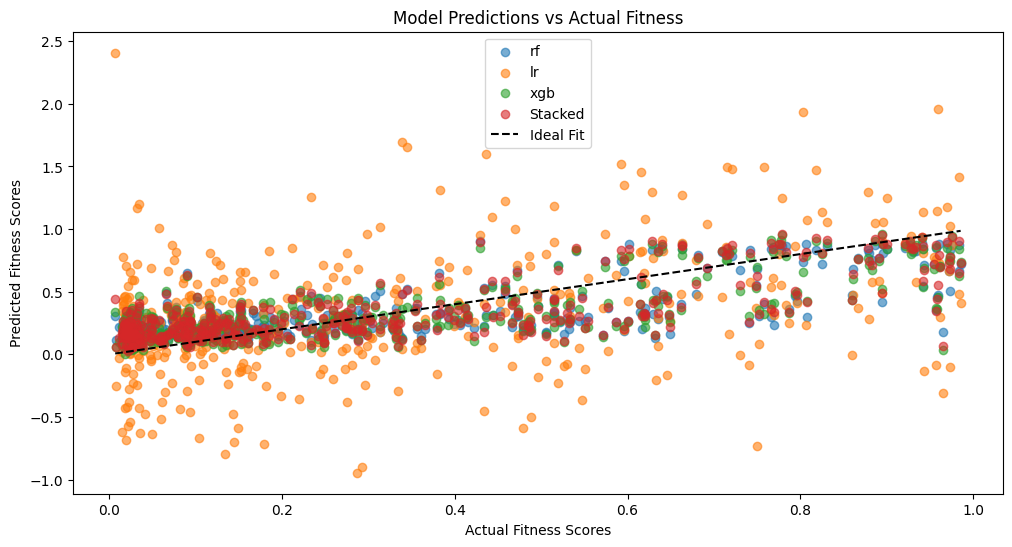

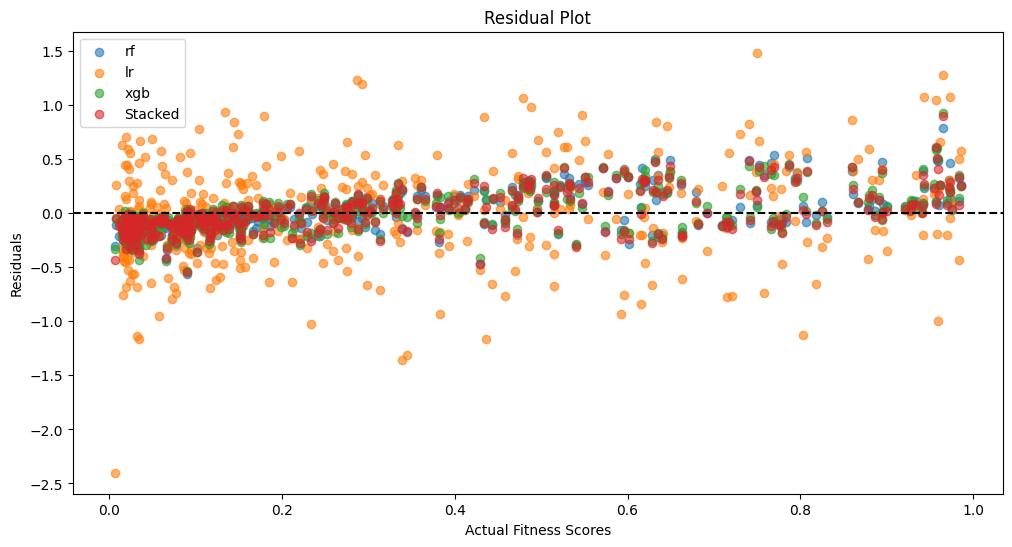

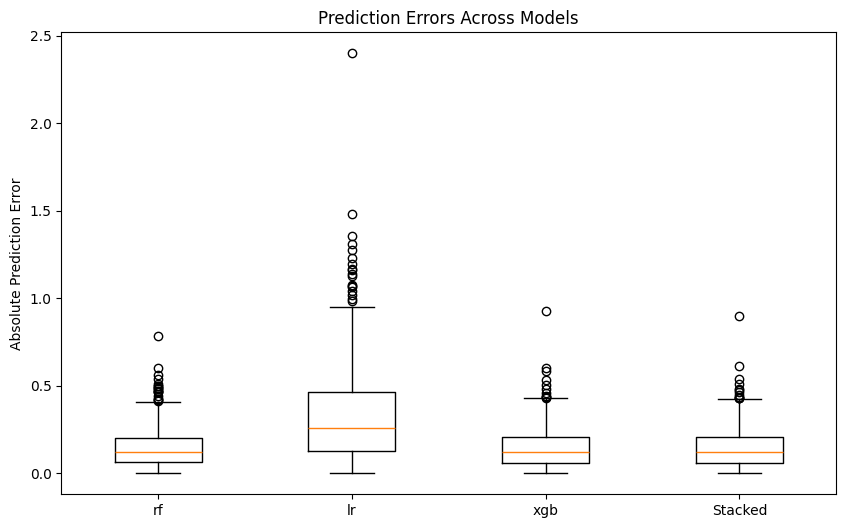

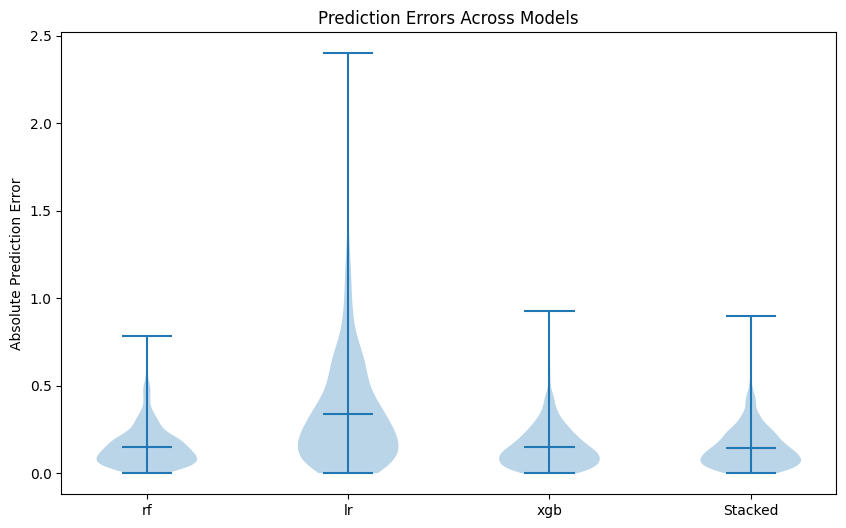

In [133]:
# Scatter plot of predictions vs actual values
plt.figure(figsize=(12, 6))
for name in pred_df.columns[:-1]:
    plt.scatter(pred_df["Actual"], pred_df[name], label=name, alpha=0.6)

plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--k', label="Ideal Fit")
plt.xlabel("Actual Fitness Scores")
plt.ylabel("Predicted Fitness Scores")
plt.title("Model Predictions vs Actual Fitness")
plt.legend()
plt.show()

# Residual Plot
plt.figure(figsize=(12, 6))
for name in pred_df.columns[:-1]:
    residuals = pred_df["Actual"] - pred_df[name]
    plt.scatter(pred_df["Actual"], residuals, label=name, alpha=0.6)

plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Actual Fitness Scores")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.legend()
plt.show()

# Boxplot of prediction errors
errors = {name: abs(pred_df["Actual"] - pred_df[name]) for name in pred_df.columns[:-1]}
plt.figure(figsize=(10, 6))
plt.boxplot(errors.values(), labels=errors.keys())
plt.ylabel("Absolute Prediction Error")
plt.title("Prediction Errors Across Models")
plt.show()

# violin plot of prediction errors
plt.figure(figsize=(10, 6))
plt.violinplot(errors.values(), showmeans=True)
plt.xticks(range(1, len(errors) + 1), errors.keys())
plt.ylabel("Absolute Prediction Error")
plt.title("Prediction Errors Across Models")
plt.show()

### 6.2 XGBoost Regression Visualizations

In [35]:
results = xgb.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']

train_mae = results['validation_0']['mae']
val_mae = results['validation_1']['mae']

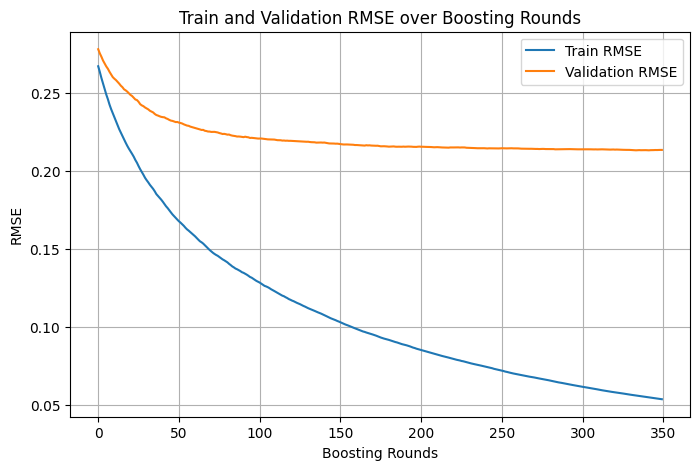

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label = 'Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Train and Validation RMSE over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()

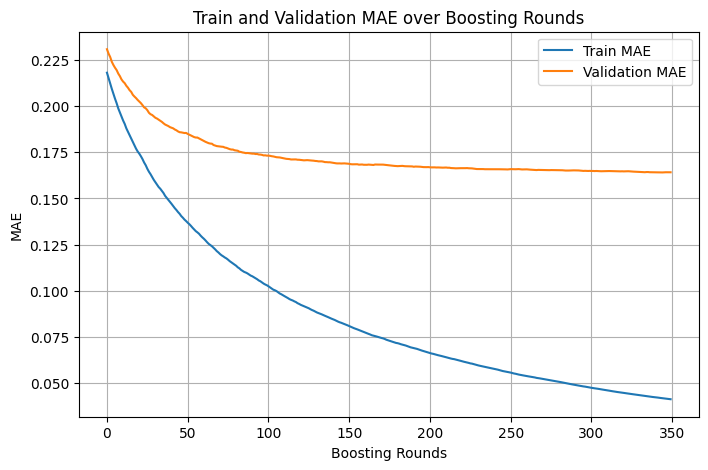

In [38]:
plt.figure(figsize=(8, 5))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label = 'Validation MAE')
plt.xlabel('Boosting Rounds')
plt.ylabel('MAE')
plt.title('Train and Validation MAE over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()